In [2]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from sklearn import (manifold, datasets, decomposition, ensemble, random_projection)
from sklearn.decomposition import LatentDirichletAllocation as lda

In [3]:
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
import scipy.io.wavfile as wav
import numpy as np
from utility import *
from proj_paths import *
import progressbar

import os
import time
from tqdm import tqdm
from python_speech_features import sigproc, mfcc, delta
from settings import *

import matplotlib.pyplot as plt

In [4]:
from sklearn.preprocessing import StandardScaler

noise_fe = load('NOISE_FEA')

print(len(noise_fe))

speech_fe = load('SPEECH_FEA')

print(len(speech_fe))

X = np.concatenate((np.array(noise_fe), np.array(speech_fe)))

print(len(X))
#  3）特征工程，标准化
transfer = StandardScaler()

X = transfer.fit_transform(X)

394
417
811


In [11]:
X

array([[-0.97872594, -0.96405155, -0.98528693, ...,  1.01249762,
        -0.53714874, -0.3883989 ],
       [-0.94247903, -0.98297613, -1.0395035 , ...,  0.69298459,
        -0.53642045, -0.38827177],
       [-0.91881326, -0.97647341, -1.08810846, ...,  0.77336484,
        -0.53809162, -0.38842666],
       ...,
       [ 2.00319047,  1.91907177,  1.01338839, ...,  0.14716149,
         2.38712042,  3.89232683],
       [ 0.87720376,  0.73776814,  0.9467496 , ..., -0.74223249,
        -0.02792178, -0.26544167],
       [ 0.79004449,  1.20824542,  1.00784175, ..., -1.02165185,
         0.1166224 , -0.17511911]])

In [45]:

# 将降维后的数据可视化,2维
def plot_embedding_2d(X, col, title=None):
    #坐标缩放到[0,1]区间
    x_min, x_max = np.min(X,axis=0), np.max(X,axis=0)
    X = (X - x_min) / (x_max - x_min)

    #降维后的坐标为（X[i, 0], X[i, 1]），在该位置画出对应的digits
    
    ax = fig.add_subplot(1, 1, 1)
    for i in range(X.shape[0]):
        ax.text(X[i, 0], X[i, 1],'d',color=col,
                 fontdict={'weight': 'bold', 'size': 9})
        

# 将降维后的数据可视化,2维
def plot_embedding_3d(X, col, title=None):
    #坐标缩放到[0,1]区间
    x_min, x_max = np.min(X,axis=0), np.max(X,axis=0)
    X = (X - x_min) / (x_max - x_min)

    #降维后的坐标为（X[i, 0], X[i, 1]），在该位置画出对应的digits
    
    ax = fig.add_subplot(1, 1, 1)
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    for i in range(X.shape[0]):
        ax.text(X[i, 0], X[i, 1], X[i, 2],'d',color=col,
                 fontdict={'weight': 'bold', 'size': 9})


Computing t-SNE embedding
(417, 3)
(394, 3)


/home/zhudong/.local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


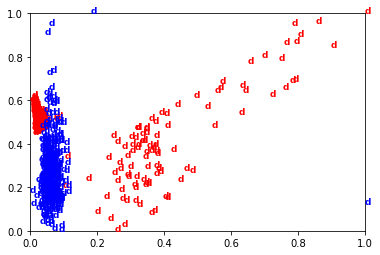

In [40]:
#%%
# t-SNE
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=3, init='pca', random_state=0)


X_tsne = tsne.fit_transform(np.array(speech_fe))
print(X_tsne.shape)
fig = plt.figure()
plot_embedding_2d(X_tsne[:,0:2], 'red', "t-SNE 2D" )

X_tsne = tsne.fit_transform(np.array(noise_fe))
print(X_tsne.shape)
plot_embedding_2d(X_tsne[:,0:2], 'blue', "t-SNE 2D")


plt.show()

Computing t-SNE embedding
(417, 3)


/home/zhudong/.local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


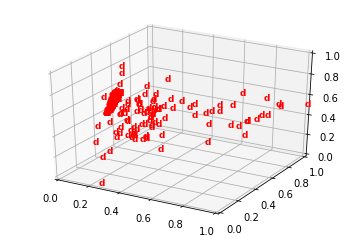

In [50]:
#%%
# t-SNE
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=3, init='pca', random_state=0)

fig = plt.figure()
X_tsne = tsne.fit_transform(np.array(speech_fe))
print(X_tsne.shape)

plot_embedding_3d(X_tsne, 'red', "t-SNE 2D" )

# X_tsne = tsne.fit_transform(np.array(noise_fe))
# print(X_tsne.shape)
# plot_embedding_3d(X_tsne, 'blue', "t-SNE 2D")

plt.show()

(394, 3)


/home/zhudong/.local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


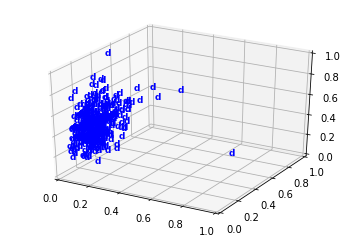

In [48]:
fig = plt.figure()
X_tsne = tsne.fit_transform(np.array(noise_fe))
print(X_tsne.shape)
plot_embedding_3d(X_tsne, 'blue', "t-SNE 2D")
plt.show()

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
class DNN(nn.Module):
    def __init__(self, num_class=2, fea_dim=156):
        super(DNN, self).__init__()
        self.layer1 = nn.Linear(fea_dim, 256)
        self.layer2 = nn.Linear(256, 512)
        self.classifier = nn.Linear(512, num_class)

    def forward(self, x):
#         out = F.relu(nn.BatchNorm1d(self.layer1(x)))
#         out2 = F.relu(nn.BatchNorm1d(self.layer2(out)))
        out = F.relu(self.layer1(x))
        out2 = F.relu(self.layer2(out))
        out = self.classifier(out2)
        return out2, out

In [7]:
net = DNN()

In [8]:
print(net)

DNN(
  (layer1): Linear(in_features=156, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=512, bias=True)
  (classifier): Linear(in_features=512, out_features=2, bias=True)
)


In [ ]:
# # mfcc_EDA,FBank40,lpc_EDA,plp_EDA
# find "../getFeatures/features/FBank40/train/"  -name  '*.npy'  >train_list.txt
# find "../getFeatures/features/FBank40/dev/" -name '*.npy' >dev_list.txt

# #
# perl get_list.pl train_list.txt lanKey.txt label_train_list.txt
# perl get_list.pl dev_list.txt   lanKey.txt label_dev_list.txt

In [59]:
!find "./dataset/train/"  -name  '*.wav'  >train_list.txt

In [60]:
!find "./dataset/test/"  -name  '*.wav'  >test_list.txt

In [62]:
!perl get_list.pl train_list.txt lanKey.txt label_train_list.txt

Data Preparation Done!


In [63]:
!perl get_list.pl test_list.txt lanKey.txt label_test_list.txt

Data Preparation Done!


In [9]:
import numpy as np

from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.utils.rnn as rnn_utils
from sklearn.preprocessing import StandardScaler


def extract(sig):
    # framing
    sig_frames = sigproc.framesig(sig=sig, frame_len=FRAME_LENGTH, frame_step=FRAME_STEP)
    
    feat = []

    def calc_all_feat(feat_coeffs):
        feat.extend(feat_coeffs.max(axis=0))
        feat.extend(feat_coeffs.min(axis=0))
        feat.extend(feat_coeffs.mean(axis=0))
        feat.extend(feat_coeffs.var(axis=0))

    # region calculate mfcc features
    mfcc_feat = mfcc(signal=sig_frames, samplerate=SAMPLE_RATE, winlen=WINDOW_LENGTH, winstep=WINDOW_STEP,
                     numcep=13, preemph=PRE_EMPH, winfunc=WINDOW_FUNCTION)
    mfcc_feat_delta = delta(mfcc_feat, 20)
    mfcc_feat_delta_delta = delta(mfcc_feat_delta, 20)

    calc_all_feat(mfcc_feat)

    calc_all_feat(mfcc_feat_delta)

    calc_all_feat(mfcc_feat_delta_delta)

    # endregion

#     # region calculate zero cross rating
#     def zcr(frames):
#         def sign(x):
#             return 1 if x >= 0 else -1

#         zc_rates = []
#         for frame in frames:
#             zc_rate = 0
#             for i in range(1, len(frame)):
#                 zc_rate += abs(sign(frame[i]) - sign(frame[i - 1])) / 2
#             zc_rates.append(zc_rate / len(frame))
#         return zc_rates

#     zcrs = zcr(sig_frames)
#     calc_all_feat(np.array([zcrs]).reshape(len(zcrs), 1))
#     # endregion

#     # region calculate energy
#     def energy(frames, eta):
#         energys = []
#         for frame in frames:
#             energy = 1 / len(frame) * np.sum(np.power(frame, 2))
#             energys.append(energy)
#         return energys

#     energys = energy(sig_frames, 0)
#     calc_all_feat(np.array([energys]).reshape(len(energys), 1))
    # endregion
    
    return feat

def normalize_frames(m, Scale=True):
    if Scale:
        return (m - np.mean(m, axis=0))/(np.std(m, axis=0)+2e-12)
    else:
        return (m - np.mean(m, axis=0))

# 数据加载
class MyDataSet(Dataset):
    def __init__(self, filepath, transform=None):
        with open(filepath) as f:
            splited_line = f.read().splitlines()
        feas = []
        for line in splited_line:
            label = int(str(line.split()[1]))
            filepath = line.split()[0]
            feas.append((filepath, label))

        self.feas = feas

    def __getitem__(self, index):
        fn, label = self.feas[index]
        
        rate, sig = wav.read(fn)
        fea = extract(sig)
        # transfer = StandardScaler()
        # fea = transfer.fit_transform(np.array([fea]))
#         print(np.array(fea))
        fea = normalize_frames(np.array(fea))
#         print(fea)
        fea = torch.FloatTensor(fea)
        return fea, label

    def __len__(self):
        return len(self.feas)


if __name__ == '__main__':
    path = 'label_train_list.txt'
    batch_size = 5

    train_dataset = MyDataSet(path)
    print('train_dataset:', train_dataset)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    print(len(train_loader))
    
    for batch_idx, (batch_x, batch_y) in enumerate(train_loader):
        batch_x = Variable(batch_x)
        print('batch_x:', batch_x, batch_x.shape)

        batch_y = Variable(batch_y)
        print('batch_y:', batch_y)

        batch_target = batch_y.contiguous().view(-1, 1).long()
        print('batch_target:', batch_target)

        break

    print('='*50)


train_dataset: <__main__.MyDataSet object at 0x7f6df3bb4320>
139


/home/zhudong/.local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


batch_x: tensor([[ 1.4601,  1.4948,  0.7375,  1.4207,  1.3338,  1.5287,  2.0215,  1.7421,
          1.8211,  1.7945,  1.4245,  1.4446,  1.2602,  1.2523,  0.5317, -0.7160,
         -0.6563, -1.2315, -1.2696, -2.0776, -1.9998, -1.8999, -1.7217, -2.0011,
         -2.0062, -2.3902,  1.3524,  1.0770,  0.0070,  0.2669, -0.0904,  0.1251,
         -0.0625,  0.0602, -0.0926, -0.0681, -0.2824, -0.2606, -0.3977, -0.2903,
         -0.0304,  0.3319,  0.8540,  1.5684,  2.2184,  2.7023,  3.1387,  3.0340,
          3.4635,  3.4387,  3.2500,  2.9909, -0.3017, -0.2942, -0.2877, -0.2820,
         -0.2797, -0.2620, -0.2659, -0.2633, -0.2620, -0.2658, -0.2640, -0.2561,
         -0.2477, -0.3069, -0.3136, -0.3203, -0.3306, -0.3329, -0.3334, -0.3389,
         -0.3432, -0.3424, -0.3546, -0.3506, -0.3393, -0.3404, -0.3044, -0.3045,
         -0.3044, -0.3046, -0.3046, -0.3044, -0.3046, -0.3043, -0.3042, -0.3042,
         -0.3042, -0.3043, -0.3043, -0.3045, -0.3043, -0.3041, -0.3038, -0.3034,
         -0.3029, -

In [10]:
# -*- coding: utf-8 -*-


import os, sys
import numpy as np
import random
from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

from sklearn import manifold
import sklearn.metrics as sm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms


def process(Trainloader, Testloader, model, criterion, optimizer, num_epochs):

    # -------------Scale and visualize the embedding vectors ----------------
    # 将降维后的数据可视化,2维
    def plot_embedding_2d(X, y, epoch, model_dir, prefix, title=None):
        # 坐标缩放到[0,1]区间

        colors = ['C0', 'C1']
        mark = ['^', 's']

        plt.figure(figsize=(8, 6), dpi=150)

        for idx, c1 in enumerate(np.unique(y)):
            plt.scatter(
                X[y == c1, 0],
                X[y == c1, 1],
                c=colors[idx],
                s=24,
                marker=mark[idx],
            )
        plt.legend(['Speech', 'Non-speech'], loc='upper right', fontsize=14)
        dirname = os.path.join(model_dir, prefix)

        if not os.path.exists(dirname):
            os.mkdir(dirname)

        if title is not None:
            plt.title(title)

        save_name = os.path.join(dirname, 'epoch_' + str(epoch) + '_2D.png')
        plt.savefig(save_name, bbox_inches='tight')

    # 将降维后的数据可视化,3维
    def plot_embedding_3d(X, y, epoch, model_dir, prefix, title=None):

        colors = ['C0', 'C1']
        mark = ['^', 's']

        fig = plt.figure(figsize=(8, 6), dpi=150)
        ax = fig.add_subplot(1, 1, 1, projection='3d')

        for idx, c1 in enumerate(np.unique(y)):
            ax.scatter(X[y == c1, 0],
                       X[y == c1, 1],
                       X[y == c1, 2],
                       color=colors[idx],
                       s=24,
                       marker=mark[idx])

        ax.legend(['Speech', 'Non-speech'], loc='upper right', fontsize=14)
        dirname = os.path.join(model_dir, prefix)

        if not os.path.exists(dirname):
            os.mkdir(dirname)

        if title is not None:
            plt.title(title)

        save_name = os.path.join(dirname, 'epoch_' + str(epoch) + '_3D.png')
        plt.savefig(save_name, bbox_inches='tight')

    # -------------------------------- train -------------------------------------
    def train(train_loader, epoch):

        model.train()  # train
        print_freq = 1

        pbar = tqdm(enumerate(train_loader))
        for batch_idx, (datas, labels) in pbar:

            datas, labels = datas.to(device), labels.to(device)

            # Forward pass
            _, outputs = model(datas)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (batch_idx + 1) % print_freq == 0:
                pbar.set_description(
                    'Train Epoch:{:3d}, Batch:[{:6d}/{:6d} ({:3.0f}%)], Loss: {:.6f}, '.format(
                        epoch, batch_idx + 1, len(train_loader), 100. * (batch_idx + 1) / len(train_loader),
                        loss.item()))

    # --------------------------------- test -------------------------------------
    def test(test_loader, epoch):

        model.eval()  # eval
        correct = 0
        total = 0
        targets, preds, last_embedding = [], [], []

        print(len(test_loader))

        with torch.no_grad():
            for batch_index, (datas, labels) in tqdm(enumerate(test_loader)):
                datas, labels = datas.to(device), labels.to(device)

                last_layer, outputs = model(datas)

                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                targets += list(labels.cpu().numpy())
                preds += list(predicted.cpu().numpy())
                last_embedding.append(last_layer.cpu().numpy()[0])

        test_acc = 100. * correct / len(test_loader.dataset)
        confusion_mtx = sm.confusion_matrix(targets, preds)

        return test_acc, confusion_mtx, np.array(last_embedding), targets

    test_accs, confusion_mtxes = [], []

    for epoch in tqdm(range(1, num_epochs+1)):

        train(Trainloader, epoch)

        test_acc, confusion_mtx, last_embedding, targets = test(Testloader, epoch)

        # t-SNE
        print("Computing t-SNE embedding ...")
        tsne = manifold.TSNE(n_components=3, init='pca', random_state=0)

        X_tsne = tsne.fit_transform(last_embedding)

        plot_embedding_2d(X_tsne[:, 0:2], targets, epoch, '../model', 'test')
        plot_embedding_3d(X_tsne, targets, epoch, '../model', 'test')

        test_accs.append(test_acc)
        confusion_mtxes.append(confusion_mtx)
        print('\rEpoch %d, Best test acc = %2.2f%%' % (epoch, max(test_accs)))

        torch.save(model, '../model/model_speech_noise_{}.pth'.format(epoch))

    return test_accs, confusion_mtxes


if __name__ == '__main__':


    train_dir = 'label_train_list.txt'
    dev_dir = 'label_test_list.txt'

    # ------------------------ Hyper parameters ----------------------------

    num_epochs = 10
    num_classes = 2
    batch_size = 120
    learning_rate = 0.001

    # ------------------------- Data loader --------------------------------
    train_dataset = MyDataSet(train_dir)
    print('train_dataset:', train_dataset)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=10)

    test_dataset = MyDataSet(dev_dir)

    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=1,
                             shuffle=False)

    print('Train data size: {}'.format(len(train_loader.dataset)))
    print('Test data size : {}'.format(len(test_loader.dataset)))

    # ------------------------------- Load model ----------------------------
#     use_cuda = torch.cuda.is_available()
    use_cuda = False

    device = torch.device("cuda:0" if use_cuda else "cpu")

    model = DNN().to(device)

    print(model)

    para = sum([np.prod(list(p.size())) for p in model.parameters()])
    # # 下面的type_size是4，因为我们的参数是float32也就是4B，4个字节
    print('\nModel {} : params: {:4f}M\n'.format(model._get_name(), para * 4 / 1024 / 1024))

    print('使用的设备是：', device)

#     # ------------------------------ Loss and optimizer ---------------------
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#     process(train_loader, test_loader, model, criterion, optimizer, num_epochs)


train_dataset: <__main__.MyDataSet object at 0x7f6df3e092e8>
Train data size: 691
Test data size : 120
DNN(
  (layer1): Linear(in_features=156, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=512, bias=True)
  (classifier): Linear(in_features=512, out_features=2, bias=True)
)

Model DNN : params: 0.659187M

使用的设备是： cpu


  0%|          | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]/home/zhudong/.local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/home/zhudong/.local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/home/zhudong/.local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/home/zhudong/.local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/home/zhudong/.local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/home/zhudong/.local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)

Train Epoch:  1, B

120



2it [00:00,  8.95it/s]
3it [00:00,  8.49it/s]
4it [00:00,  8.79it/s]
5it [00:00,  8.34it/s]
6it [00:00,  8.11it/s]
7it [00:00,  7.94it/s]
8it [00:00,  7.87it/s]
9it [00:01,  7.89it/s]
10it [00:01,  7.79it/s]
11it [00:01,  7.83it/s]
12it [00:01,  7.88it/s]
13it [00:01,  7.73it/s]
14it [00:01,  8.17it/s]
16it [00:01,  9.14it/s]
17it [00:01,  9.26it/s]
19it [00:02,  9.84it/s]
21it [00:02, 10.36it/s]
23it [00:02,  9.68it/s]
24it [00:02,  9.03it/s]
25it [00:02,  8.67it/s]
26it [00:02,  8.19it/s]
27it [00:03,  7.89it/s]
28it [00:03,  7.70it/s]
29it [00:03,  7.47it/s]
30it [00:03,  7.51it/s]
31it [00:03,  7.49it/s]
32it [00:03,  7.28it/s]
33it [00:03,  7.57it/s]
34it [00:04,  7.47it/s]
35it [00:04,  7.50it/s]
36it [00:04,  7.36it/s]
37it [00:04,  7.49it/s]
38it [00:04,  7.45it/s]
39it [00:04,  7.59it/s]
40it [00:04,  7.52it/s]
41it [00:04,  7.60it/s]
42it [00:05,  7.70it/s]
43it [00:05,  7.67it/s]
44it [00:05,  7.74it/s]
45it [00:05,  7.35it/s]
47it [00:05,  8.52it/s]
48it [00:05,  8.82it/s]

Computing t-SNE embedding ...


/home/zhudong/.local/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type DNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
 10%|█         | 1/10 [00:53<07:59, 53.30s/it]

Epoch 1, Best test acc = 100.00%



/home/zhudong/.local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
0it [00:00, ?it/s]/home/zhudong/.local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/home/zhudong/.local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/home/zhudong/.local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/home/zhudong/.local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/home/zhudong/.local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)

Train Epoch:  2, Batch:[     1/     6 ( 17%)], Loss: 0.2

120



3it [00:00,  8.24it/s]
5it [00:00,  8.89it/s]
6it [00:00,  9.05it/s]
7it [00:00,  9.29it/s]
9it [00:00,  9.80it/s]
11it [00:01, 10.09it/s]
13it [00:01, 10.34it/s]
14it [00:01, 10.11it/s]
16it [00:01, 10.31it/s]
18it [00:01, 10.13it/s]
20it [00:01, 10.15it/s]
22it [00:02,  8.98it/s]
23it [00:02,  8.65it/s]
24it [00:02,  8.30it/s]
25it [00:02,  7.26it/s]
27it [00:02,  8.20it/s]
29it [00:03,  8.74it/s]
31it [00:03,  9.35it/s]
32it [00:03,  9.38it/s]
34it [00:03,  9.99it/s]
36it [00:03,  9.02it/s]
37it [00:03,  8.54it/s]
38it [00:04,  8.88it/s]
40it [00:04,  9.14it/s]
41it [00:04,  8.51it/s]
42it [00:04,  8.17it/s]
43it [00:04,  7.91it/s]
44it [00:04,  8.11it/s]
45it [00:04,  7.16it/s]
46it [00:05,  7.72it/s]
48it [00:05,  7.75it/s]
49it [00:05,  7.52it/s]
50it [00:05,  7.50it/s]
51it [00:05,  7.49it/s]
52it [00:05,  7.31it/s]
53it [00:05,  7.41it/s]
54it [00:06,  7.28it/s]
55it [00:06,  7.43it/s]
56it [00:06,  7.20it/s]
57it [00:06,  7.20it/s]
58it [00:06,  7.19it/s]
59it [00:06,  7.26it

Computing t-SNE embedding ...


/home/zhudong/.local/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type DNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
 20%|██        | 2/10 [01:47<07:07, 53.45s/it]

Epoch 2, Best test acc = 100.00%


/home/zhudong/.local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)

/home/zhudong/.local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
0it [00:00, ?it/s]/home/zhudong/.local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/home/zhudong/.local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/home/zhudong/.local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/home/zhudong/.local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)

Train Epoch:  3, Batch:[     1/     6 ( 17%)], Loss: 0.0

120



3it [00:00, 11.01it/s]
5it [00:00, 10.54it/s]
7it [00:00, 10.49it/s]
9it [00:00, 10.75it/s]
11it [00:01, 10.69it/s]
13it [00:01, 10.72it/s]
15it [00:01, 10.80it/s]
17it [00:01, 10.48it/s]
19it [00:01, 10.38it/s]
21it [00:02, 10.19it/s]
22it [00:02,  9.04it/s]
24it [00:02,  9.71it/s]
25it [00:02,  9.68it/s]
26it [00:02,  9.59it/s]
27it [00:02,  9.31it/s]
28it [00:02,  9.39it/s]
29it [00:02,  8.86it/s]
30it [00:03,  8.82it/s]
31it [00:03,  8.48it/s]
32it [00:03,  7.72it/s]
33it [00:03,  7.77it/s]
34it [00:03,  7.78it/s]
35it [00:03,  7.51it/s]
36it [00:03,  7.36it/s]
37it [00:03,  7.40it/s]
38it [00:04,  7.25it/s]
39it [00:04,  7.42it/s]
40it [00:04,  7.39it/s]
41it [00:04,  7.38it/s]
42it [00:04,  7.17it/s]
44it [00:04,  8.10it/s]
45it [00:04,  8.06it/s]
46it [00:05,  8.16it/s]
48it [00:05,  9.14it/s]
49it [00:05,  9.13it/s]
51it [00:05,  9.50it/s]
52it [00:05,  9.47it/s]
54it [00:05,  9.47it/s]
56it [00:06,  9.95it/s]
58it [00:06, 10.07it/s]
60it [00:06, 10.43it/s]
62it [00:06, 10.15i

Computing t-SNE embedding ...


/home/zhudong/.local/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type DNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
 30%|███       | 3/10 [02:40<06:14, 53.56s/it]

Epoch 3, Best test acc = 100.00%


/home/zhudong/.local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/home/zhudong/.local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)

0it [00:00, ?it/s]/home/zhudong/.local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/home/zhudong/.local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/home/zhudong/.local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/home/zhudong/.local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)

Train Epoch:  4, Batch:[     1/     6 ( 17%)], Loss: 0.0

120



2it [00:00,  8.38it/s]
3it [00:00,  8.05it/s]
4it [00:00,  7.95it/s]
5it [00:00,  7.52it/s]
6it [00:00,  7.45it/s]
7it [00:00,  7.95it/s]
8it [00:01,  7.45it/s]
9it [00:01,  7.41it/s]
10it [00:01,  7.40it/s]
11it [00:01,  7.91it/s]
13it [00:01,  8.68it/s]
14it [00:01,  8.82it/s]
16it [00:01,  9.22it/s]
17it [00:02,  8.80it/s]
18it [00:02,  8.86it/s]
19it [00:02,  8.43it/s]
20it [00:02,  7.92it/s]
21it [00:02,  7.45it/s]
23it [00:02,  8.46it/s]
25it [00:02,  9.39it/s]
27it [00:03,  8.68it/s]
28it [00:03,  8.11it/s]
29it [00:03,  7.76it/s]
30it [00:03,  7.63it/s]
31it [00:03,  7.69it/s]
32it [00:03,  7.27it/s]
34it [00:04,  8.16it/s]
35it [00:04,  8.63it/s]
36it [00:04,  7.93it/s]
37it [00:04,  7.82it/s]
38it [00:04,  7.54it/s]
39it [00:04,  7.69it/s]
40it [00:04,  7.43it/s]
41it [00:04,  7.56it/s]
42it [00:05,  7.71it/s]
43it [00:05,  7.74it/s]
44it [00:05,  7.70it/s]
45it [00:05,  7.27it/s]
46it [00:05,  7.14it/s]
47it [00:05,  7.46it/s]
48it [00:05,  6.79it/s]
50it [00:06,  7.68it/s]

KeyboardInterrupt: 

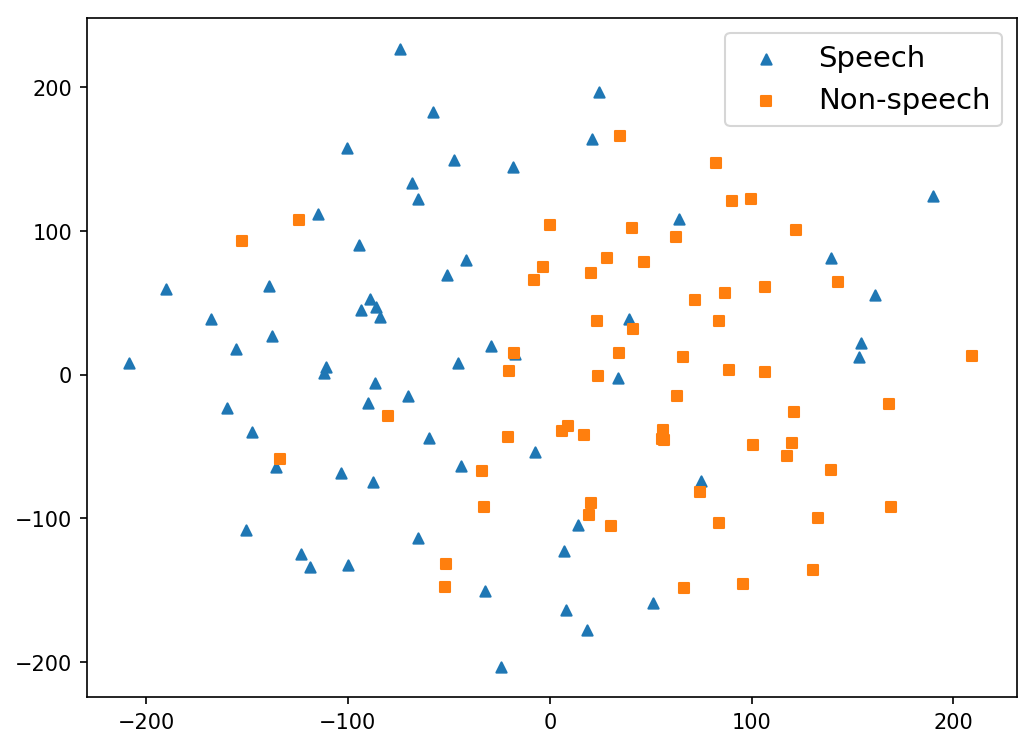

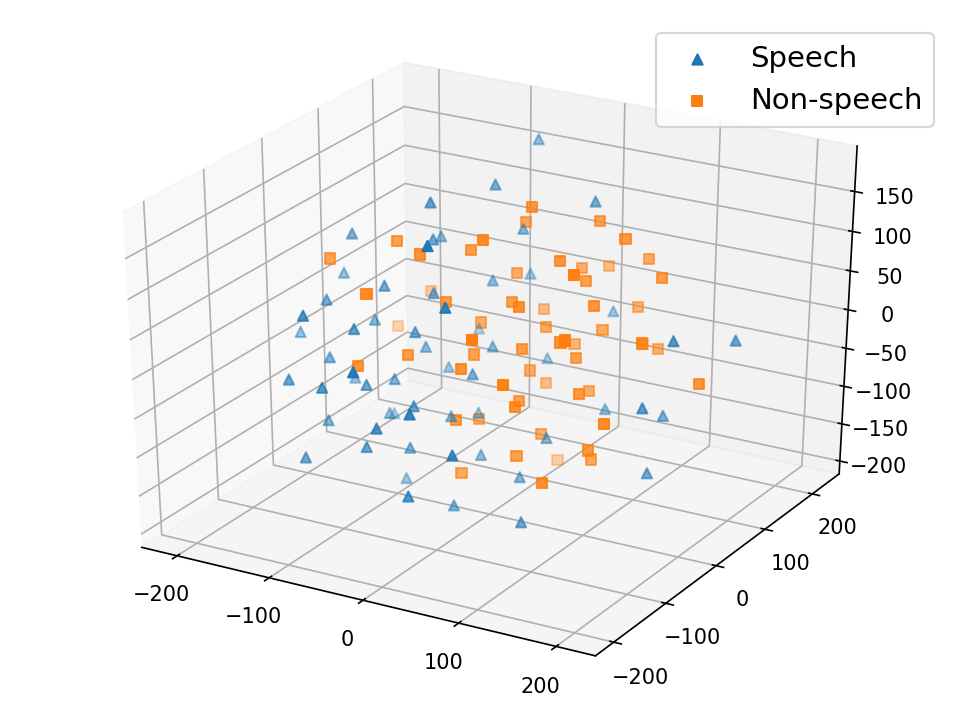

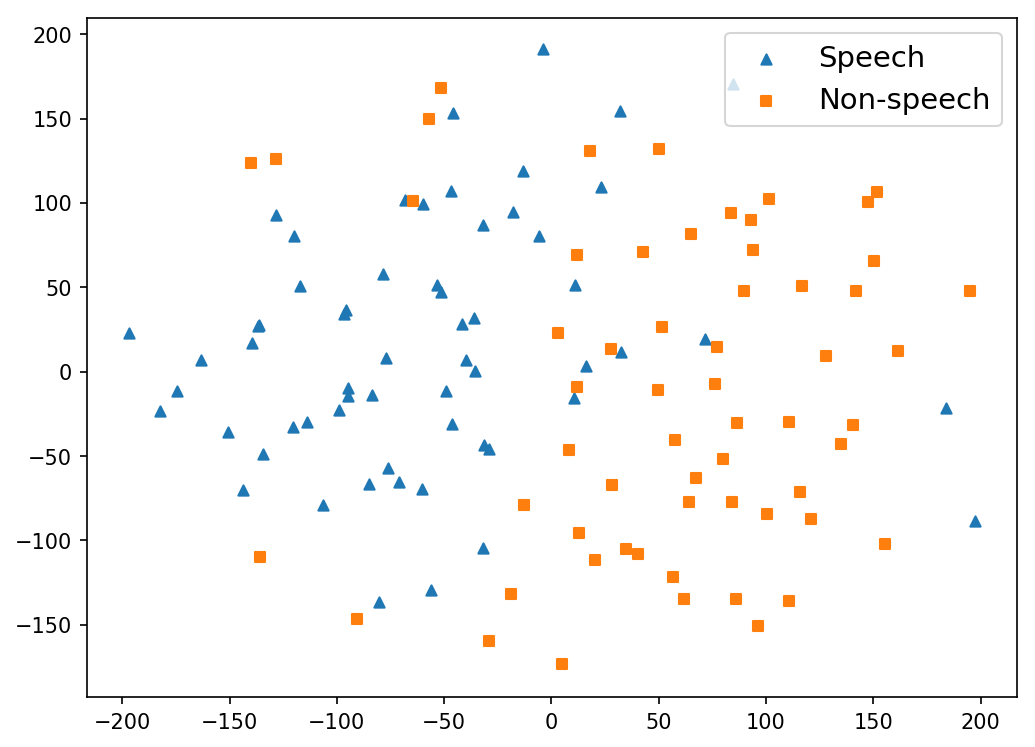

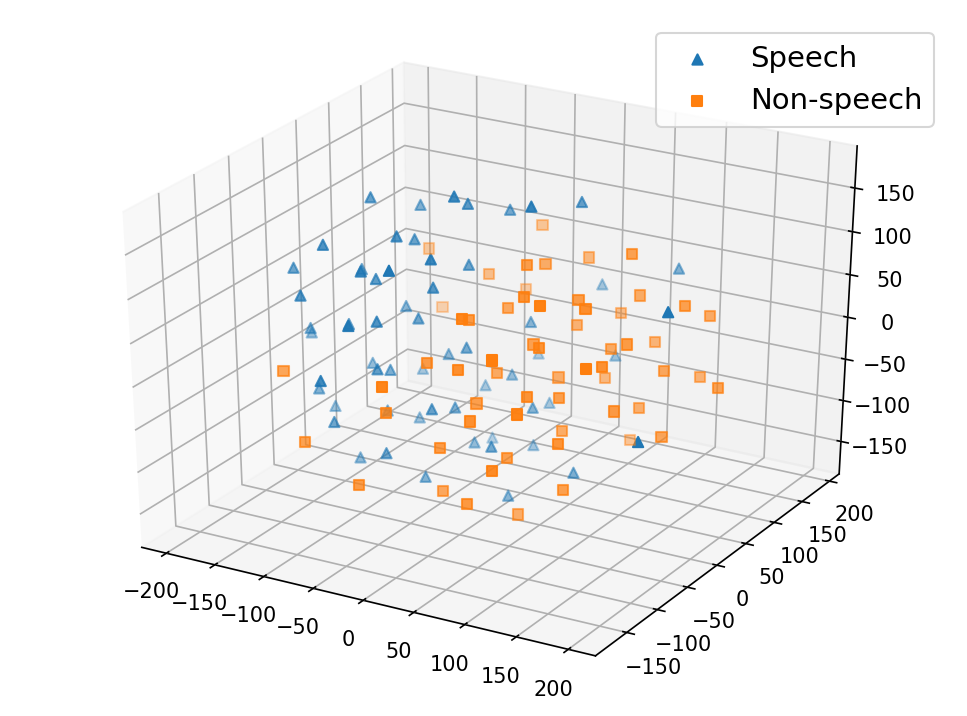

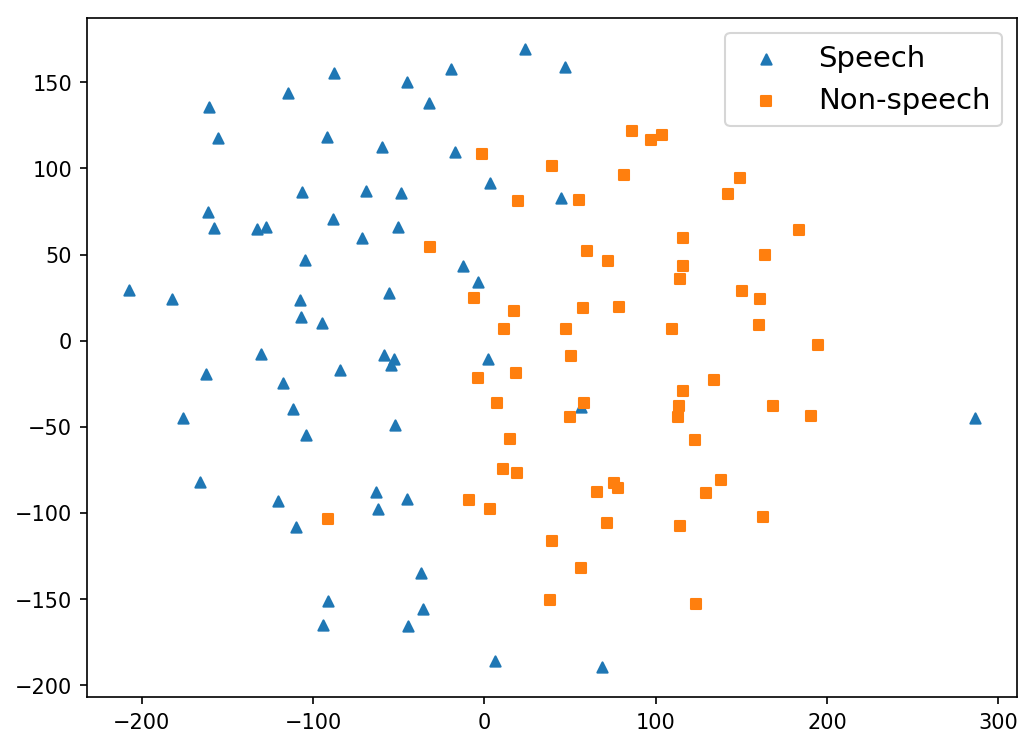

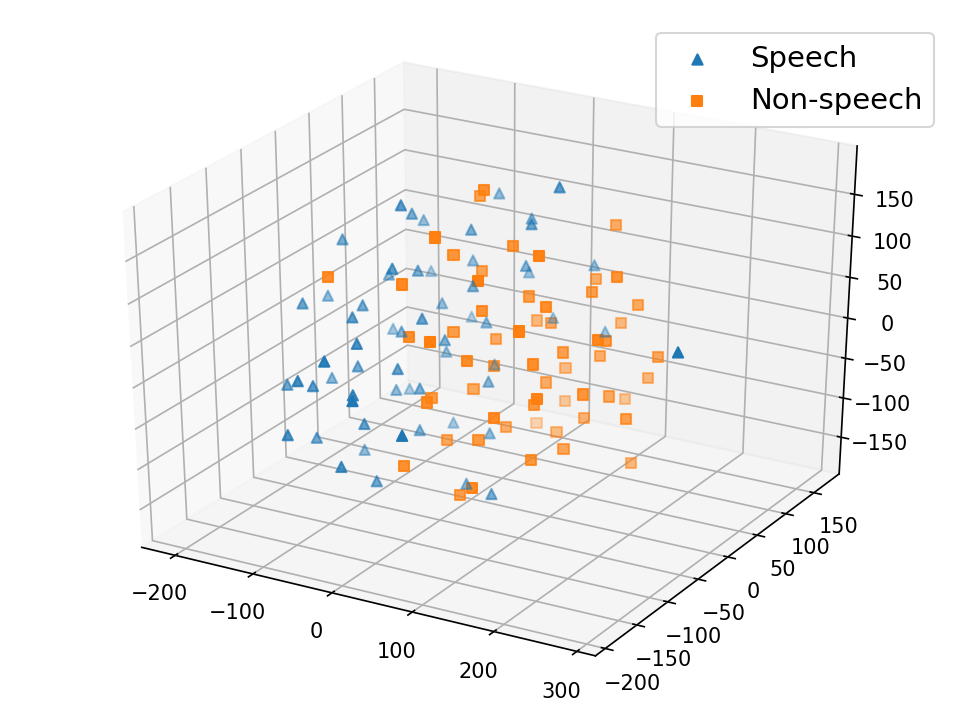

In [11]:
# ------------------------------ Loss and optimizer ---------------------
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

process(train_loader, test_loader, model, criterion, optimizer, num_epochs)

In [3]:
import torch

loss_fn = torch.nn.MSELoss(reduce=False, size_average=False) 
input = torch.autograd.Variable(torch.randn(3,4)) 
target = torch.autograd.Variable(torch.randn(3,4)) 
loss = loss_fn(input, target) 
print(input); print(target); 
print(loss) 
print(input.size(), target.size(), loss.size())


tensor([[-0.7511, -1.5549,  0.1383, -0.6892],
        [ 0.0452, -1.4538,  1.7936, -1.2604],
        [-1.6505, -0.0712,  0.4316,  1.3635]])
tensor([[-0.3595,  0.1325,  1.8500,  0.6126],
        [-0.6423, -0.8940, -0.9816, -0.6319],
        [-0.2052,  0.2200, -1.6245,  1.0445]])
tensor([[0.1534, 2.8474, 2.9299, 1.6947],
        [0.4728, 0.3134, 7.7017, 0.3950],
        [2.0888, 0.0848, 4.2277, 0.1017]])
torch.Size([3, 4]) torch.Size([3, 4]) torch.Size([3, 4])


/home/zhudong/.local/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
